In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
import nltk

In [2]:
data = pd.read_csv('C:/Users/John/Documents/ml_projects/tripadvisor_reviews/data/tripadvisor_hotel_cleaned_reviews.csv', )
data.head()

,Review,Rating,cleaned_text,stemmed_review
0,nice hotel expensive parking got good deal sta...,4,nice hotel expensive parking got good deal sta...,nice hotel expens park got good deal stay hote...
1,ok nothing special charge diamond member hilto...,2,nothing special charge diamond member hilton d...,noth special charg diamond member hilton decid...
2,nice rooms not 4* experience hotel monaco seat...,3,nice rooms not experience hotel monaco seattle...,nice room not experi hotel monaco seattl good ...
3,"unique, great stay, wonderful time hotel monac...",5,unique great stay wonderful time hotel monaco ...,uniqu great stay wonder time hotel monaco loca...
4,"great stay great stay, went seahawk game aweso...",5,great stay great stay went seahawk game awesom...,great stay great stay went seahawk game awesom...


We will change the ratings to show sentiment as the model will determine if the review is positive, neutral or negative

In [3]:
def rating_to_sentiment(num):
    if num == 1 or num == 2:
        return 0
    if num == 3:
        return 1
    else:
        return 2

data['sentiment'] = data['Rating'].apply(rating_to_sentiment)
data.head()

,Review,Rating,cleaned_text,stemmed_review,sentiment
0,nice hotel expensive parking got good deal sta...,4,nice hotel expensive parking got good deal sta...,nice hotel expens park got good deal stay hote...,2
1,ok nothing special charge diamond member hilto...,2,nothing special charge diamond member hilton d...,noth special charg diamond member hilton decid...,0
2,nice rooms not 4* experience hotel monaco seat...,3,nice rooms not experience hotel monaco seattle...,nice room not experi hotel monaco seattl good ...,1
3,"unique, great stay, wonderful time hotel monac...",5,unique great stay wonderful time hotel monaco ...,uniqu great stay wonder time hotel monaco loca...,2
4,"great stay great stay, went seahawk game aweso...",5,great stay great stay went seahawk game awesom...,great stay great stay went seahawk game awesom...,2


# Naive Bayes Model

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB

In [122]:
vectorizer = TfidfVectorizer(max_features=10000)
x_train, x_test, y_train, y_test = train_test_split(data['cleaned_text'], data['sentiment'], test_size=0.3, random_state=1)
x_train = vectorizer.fit_transform(x_train)
x_test = vectorizer.transform(x_test)

In [6]:
nb_model = MultinomialNB()
nb_model.fit(x_train, y_train)
pred_y = nb_model.predict(x_test)

In [7]:
# Check how the model is performing
def show_performance(y_test, pred_y, model_name):
    accuracy = accuracy_score(y_test, pred_y)
    c_matrix = confusion_matrix(y_test, pred_y)
    score = f1_score(y_test, pred_y, average=None)
    labels = ['Negative', 'Neutral', 'Positive']
    print('accuracy: ', accuracy)
    print('f1 score: ', score)
    sns.heatmap(c_matrix, annot=True, cmap='Blues', fmt='.0f', xticklabels = labels, yticklabels = labels)
    plt.xlabel('Predicted Sentiment')
    plt.ylabel('True Sentiment')
    plt.title(model_name + ' Model Performance')
    plt.show()

accuracy:  0.8041639557579701
f1 score:  [0.57746479 0.         0.88511469]


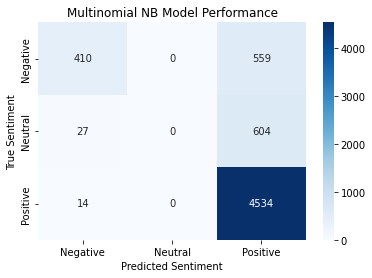

In [8]:
show_performance(y_test, pred_y, 'Multinomial NB')

# Random Forest Model

In [9]:
from sklearn.ensemble import RandomForestClassifier

In [10]:
rf_model = RandomForestClassifier()
rf_model.fit(x_train, y_train)
pred_y = rf_model.predict(x_test)

accuracy:  0.8126219908913468
f1 score:  [0.61920752 0.         0.89131289]


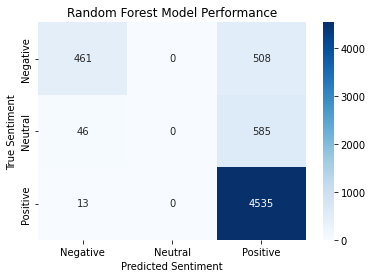

In [11]:
show_performance(y_test, pred_y, 'Random Forest')

# XGBoost Model

In [12]:
import xgboost as xgb

In [13]:
xgb_model = xgb.XGBClassifier()
xgb_model.fit(x_train, y_train)
pred_y = xgb_model.predict(x_test)

accuracy:  0.8475927130774236
f1 score:  [0.75374732 0.23798627 0.92170819]


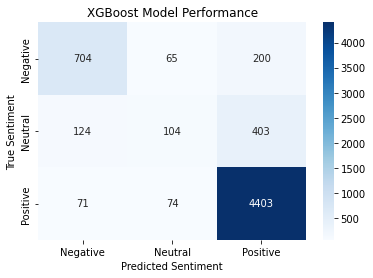

In [14]:
show_performance(y_test, pred_y, 'XGBoost')

# Logistic Regression Model

In [15]:
from sklearn.linear_model import LogisticRegression

accuracy:  0.8643461288223813
f1 score:  [0.8        0.25721154 0.92994563]


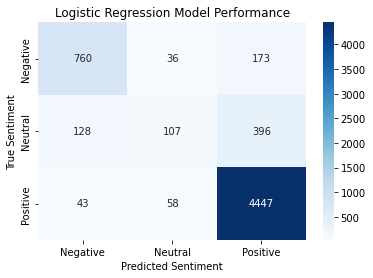

In [123]:
lr_model = LogisticRegression(max_iter=10000)
lr_model.fit(x_train, y_train)
pred_y = lr_model.predict(x_test)
show_performance(y_test, pred_y, 'Logistic Regression')


Looking at the performance of all four models, it is seen that random forest and multinomial naive bayes performed worse than xgboost and logistic regression. From the confusion matrix, it is shown that it does not like predicting a neutral sentiment and only predicts positive or negative. This could be due to the low number of neutral sentiment data it was trained on. The best model was the logistic regression model with an accuracy of 86% and the xgboost model coming in second with an accuracy of 85%. Both models are very close to one another in accuracy and f1 scores but the f1 score for a negative sentiment is about 5% higher in the logistic regression model. 

Lets try some random test sentences scenarios

In [126]:
def test_sentences(sentence):
    test_sent = [sentence]
    test_sent = vectorizer.transform(test_sent)
    test_pred = lr_model.predict(test_sent)
    if test_pred == 0:
        print('Negative sentiment')
    elif test_pred == 1:
        print('Neutral sentiment')
    else:
        print('Positive sentiment')

In [127]:
test_sentences('I really enjoyed my stay at the hotel')

Positive sentiment


In [130]:
test_sentences('The rooms at the hotel was okay.')

Negative sentiment


In [131]:
test_sentences('I would not recommend stayying at this hotel. Staff was not friendly whatsoever')

Negative sentiment


In [132]:
test_sentences('I would say that I really enjoyed my stay at the hotel but that would be lying')

Positive sentiment


In [139]:
test_sentences('Loved how the staff here are not working')

Positive sentiment


From these sentences, it has a hard time differentiating a negative and neutral sentiment. It fails to predict reviews that are a bit sarcastic and key words that stimulate positive sentiment has a strong effect on the overall sentence sentiment.

# Neural Network
Lets try a neural network utilizing transfer learning to have pre-trained word embeddings

In [17]:
from keras.utils import to_categorical, pad_sequences
import tensorflow as tf
from keras.preprocessing.text import Tokenizer
import gensim.downloader
from tensorflow.keras.layers import Dense, Input, LSTM, Dropout, Embedding, Bidirectional, BatchNormalization
from tensorflow.keras.models import Model

In [18]:
# We will decrease the ratings by one to start the rating from 0-4 instead of 1-5
x = to_categorical(data['sentiment'])
x

array([[0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.],
       ...,
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.]], dtype=float32)

In [19]:
# Load in the pre-trained word embeddings 
glove_vectors = gensim.downloader.load('glove-twitter-50')

In [20]:
# Split the data, tokenize and pad the sentences. Any words not seen by the model for the test data will be seen as an oov token.
x_train, x_test, y_train, y_test = train_test_split(data['cleaned_text'], x, test_size=0.2)
num_words = 10000
tokenizer = Tokenizer(num_words, lower=True, oov_token = True)
tokenizer.fit_on_texts(x_train)

# pad
x_train = tokenizer.texts_to_sequences(x_train)
x_train = pad_sequences(x_train, maxlen = 50, padding = 'post')
x_test = tokenizer.texts_to_sequences(x_test)
x_test = pad_sequences(x_test, maxlen = 50, padding = 'post')

In [21]:
# Instantiate a weight matrix of each word and its vector size (50 in our case as we are using the glove 50 dimensional weights)
weight_matrix = np.zeros((num_words, 50))

# If the word in the tokenizer is in the glove embedding, the weight matrix will take the glove embedding vector as its value
for word, index in tokenizer.word_index.items():
    if index < num_words:
        if word in glove_vectors.index_to_key:
            weight_matrix[index] = glove_vectors[word]
        else:
            weight_matrix[index] = np.zeros(50)
            

In [45]:
input_ = Input(shape=(50,))
x = Embedding(input_dim = num_words,
                output_dim = 50, 
                input_length = x_train.shape[1], 
                weights = [weight_matrix], trainable=False)(input_)
x = Bidirectional(LSTM(64, return_sequences = False))(x)
x = Dropout(rate=0.8)(x)
output = Dense(3, activation = 'softmax')(x)
model = Model(inputs = input_, outputs = output)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [46]:
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 50)]              0         
                                                                 
 embedding_4 (Embedding)     (None, 50, 50)            500000    
                                                                 
 bidirectional_7 (Bidirectio  (None, 128)              58880     
 nal)                                                            
                                                                 
 dropout_7 (Dropout)         (None, 128)               0         
                                                                 
 dense_8 (Dense)             (None, 3)                 387       
                                                                 
Total params: 559,267
Trainable params: 59,267
Non-trainable params: 500,000
________________________________________________

In [47]:
model_fit = model.fit(x_train, y_train, epochs = 30, validation_data = (x_test, y_test), batch_size = 64, verbose = False)

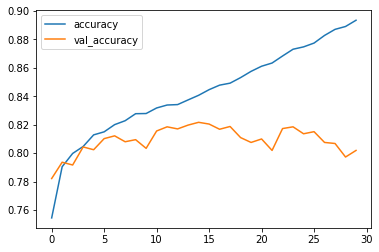

In [52]:
plt.plot(model_fit.history['accuracy'], label='accuracy')
plt.plot(model_fit.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.show()

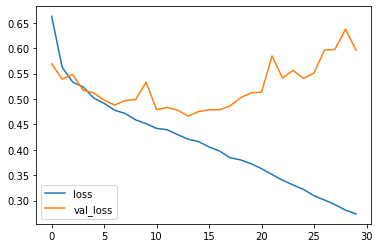

In [53]:
plt.plot(model_fit.history['loss'], label='loss')
plt.plot(model_fit.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

In [50]:
y_pred = model.predict(x_test)

129/129 [==============================] - 2s 10ms/step


accuracy:  0.8019029031471091
f1 score:  [0.64877664 0.20989505 0.89591315]


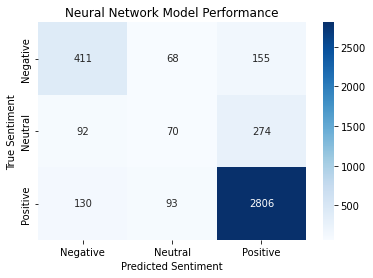

In [54]:
show_performance(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1), 'Neural Network')

As with the logistic regression, lets try out some test sentences with the neural network

In [125]:
# Test a random sentence
def test_sentences_nn(sentence):
    test_sent = [sentence]
    test_sent = tokenizer.texts_to_sequences(test_sent)
    test_sent = pad_sequences(test_sent, maxlen = 50, padding = 'post')
    test_pred = np.argmax(model.predict(test_sent, verbose=0))
    if test_pred == 0:
        print('Negative sentiment')
    elif test_pred == 1:
        print('Neutral sentiment')
    else:
        print('Positive sentiment')

In [140]:
test_sentences_nn('I really enjoyed my stay at the hotel')

Positive sentiment


In [141]:
test_sentences_nn('The rooms at the hotel was okay.')

Neutral sentiment


In [142]:
test_sentences_nn('I would not recommend stayying at this hotel. Staff was not friendly whatsoever')

Negative sentiment


In [143]:
test_sentences_nn('I would say that I really enjoyed my stay at the hotel but that would be lying')

Negative sentiment


In [144]:
test_sentences_nn('Loved how the staff here are not working')

Positive sentiment


From the same sentences and comparing the predicted sentiment, the neural network was able to detect the overall sentiment of a sentence a bit better (the neutral sentiment sentence and the sentence that was lying). The sentence "loved how the staff here are not working" was both perceived as positive when in fact would be a negative sentiment.

# Overall thoughts

Overall, the logistic regression model had the best performance, but the neural network model had better predictions on the test case sentences. This could be due to the LSTM layer in the neural network which allows it to carry certain weights that affects the sentiment from earlier towards the later part of the sentence. More testing will be required to determine which model performs best in the real world. 